In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/SEOP-and-NMR.git

# add path to .py files for import
import sys
sys.path.insert(1, "/content/SEOP-and-NMR/src")

Cloning into 'SEOP-and-NMR'...
remote: Enumerating objects: 582, done.
remote: Counting objects: 100% (582/582), done.
remote: Compressing objects: 100% (521/521), done.
remote: Total 582 (delta 340), reused 130 (delta 52), pack-reused 0
Receiving objects: 100% (582/582), 16.85 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (340/340), done.


In [2]:
# PYTHON PACKAGES
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import inv
import matplotlib.pyplot as plt
import copy as cp
np.random.seed(14)

# MY PACKAGES
import physical_constant_units as phy
import measurements as meas
import environment as env
import xenon as xe
import utils

/content/SEOP-and-NMR/src/measurements.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Dual species open-loop simulation with magnetic noise

In this simulation we generate constant magnetic field $B_0\hat{z}$ and magnetic noise $B_{noise}(t)$ and simulating the dynameics of two Xenon species in an open-loop configuration (without feedback). We compute the phase of each one of the two Xenons species with respect to their drive 

$$
\begin{align}
    \phi_{129}(t) &= -\frac{\gamma^{129}_{Xe}B_0(t)}{\Gamma_2^{129}}-\frac{\gamma^{129}_{Xe}B_{noise}(t)}{\Gamma_2^{129}}-\frac{\omega_r(t)}{\Gamma_2^{129}}+\frac{\omega^{129}_{rf}(t)}{\Gamma_2^{129}}\\
    \phi_{131}(t) &= -\frac{\gamma^{131}_{Xe}B_0(t)}{\Gamma_2^{131}}-\frac{\gamma^{131}_{Xe}B_{noise}(t)}{\Gamma_2^{131}}-\frac{\omega_r(t)}{\Gamma_2^{131}}+\frac{\omega^{131}_{rf}(t)}{\Gamma_2^{131}}
\end{align}
$$

from these two equations we can subtract the magnetic noise along the $\hat{z}$ axis and calculate the world rotation $\omega_r (t)$ as follows:

$$
\begin{align}
   B_{noise}(t)  &= -\frac{\Gamma_2^{129}}{\gamma^{129}_{Xe}}\phi_{129}(t)-B_0 (t)-\frac{\omega_r (t)}{\gamma^{129}_{Xe}}+\frac{\omega^{129}_{rf} (t)}{\gamma^{129}_{Xe}}
\end{align}
$$

thus,

$$
\begin{align}
        \omega_r (t) &= \left[\frac{ \gamma^{129}_{Xe} \gamma^{131}_{Xe} }{\gamma^{129}_{Xe} - \gamma^{131}_{Xe}}\right]\left[\frac{1}{\gamma^{129}_{Xe}}\left(\phi_{129} (t)\Gamma_2^{129}-\omega^{129}_{rf} (t)\right) - \frac{1}{\gamma^{131}_{Xe}}\left(\phi_{131} (t)\Gamma_2^{131}-\omega^{131}_{rf} (t)\right)\right]
\end{align}
$$

### Dual species simulation for sigmoid-like world rotation signal

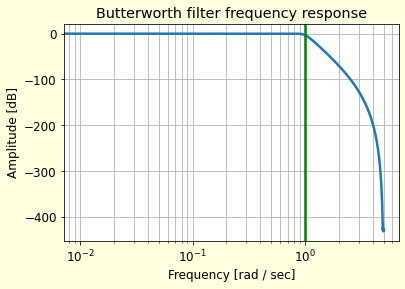

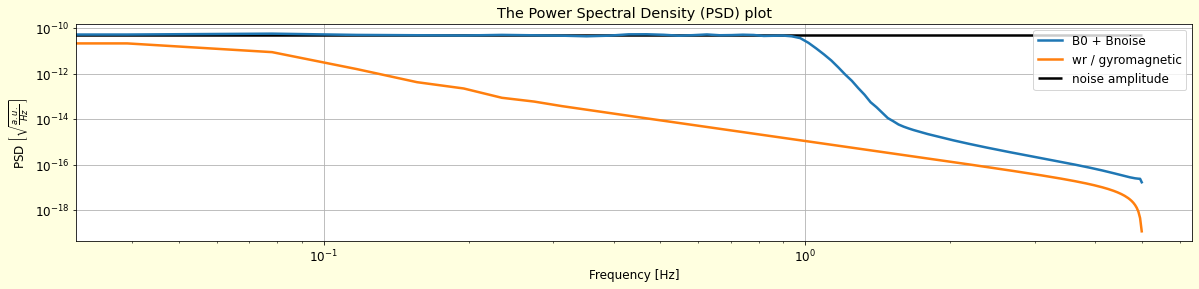

In [23]:
# solver and noise parameters
t_final = 1000                               # [s]
dt = 0.1                                      # [s]
sampling_frequency = 1 / dt                 # [Hz]
noise_cutoff_frequency = 1                # [Hz]
noise_amplitude = 5e-7 * phy.G2T            # [Tesla]
steps = int(t_final // dt)
ts = np.linspace(0, t_final, steps)         # [s]
noise = utils.get_white_noise(noise_amplitude, sampling_frequency, ts)  # [Tesla]

# world rotation parameters
#wr = 30 * utils.gaussian(ts, 600, 40)                         # rad / s     
wr = 0.01 * utils.sigmoid(ts, 0.5, 100)                          # rad / s   

# Xenon 129 parameters
g129 = phy.G129                            # gyromagnetic ratio [rad  s^-1  T^-1]
t1_129 = 30                                # s
t2_129 = 8                                 # s
Rse_129 = np.array([0, 0, 0.1]) * t1_129   # |K| / s


# Xenon 131 parameters
g131 = phy.G131                            # gyromagnetic ratio [rad  s^-1  T^-1]
t1_131 = 30                                # s
t2_131 = 8                                 # s
Rse_131 = np.array([0, 0, 0.1]) * t1_131   # |K| / s


# Environment parameters
B0 = 1e-6 * phy.G2T * np.ones_like(ts)    # Tesla 
Bnoise = utils.butter_low_pass_filter(noise, 10, noise_cutoff_frequency, sampling_frequency, plot_filter=True)

Ad_y_129 = 2 * np.sqrt((1 / t1_129) * (1 / t2_129)) * np.ones_like(ts)  # rad / s
wd_y_129 = g129 * 1e-6 * phy.G2T * np.ones_like(ts)                        # rad / s
Ad_x_129 = np.zeros_like(ts)                                            # rad / s
wd_x_129 = np.zeros_like(ts)                                            # rad / s
Ad_y_131 = 2 * np.sqrt((1 / t1_131) * (1 / t2_131)) * np.ones_like(ts)  # rad / s
wd_y_131 = g131 * 1e-6 * phy.G2T * np.ones_like(ts)                        # rad / s
Ad_x_131 = np.zeros_like(ts)                                            # rad / s
wd_x_131 = np.zeros_like(ts)                                            # rad / s

# PSD plot of all signals
signal_list = [B0 + Bnoise, wr / g129]
names = ['B0 + Bnoise', 'wr / gyromagnetic']
utils.psd_compare(signal_list, sampling_frequency, noise_amplitude=noise_amplitude, names=names, logx=True)


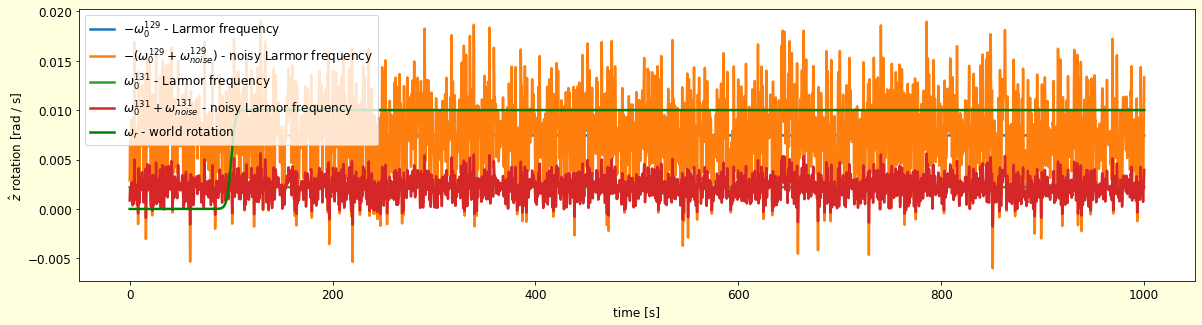

In [24]:
# initialize Xenon 129
Xe129 = xe.Xenon(gamma=g129, t1=t1_129, t2=t2_129, K0=np.array([0.059, 0.42, -0.1]), ts=t_final, dt=dt, name='129')
Xe129.set_spin_exchange_amp(Rse_129)

# initialize Xenon 131
Xe131 = xe.Xenon(gamma=g131, t1=t1_131, t2=t2_131, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='131')
Xe131.set_spin_exchange_amp(Rse_131)

# initialize Xenon-129 Environment
env129 = env.Environment(name='Xenon-129 environment')
env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y_129, wd_y=wd_y_129, Ad_x=Ad_x_129, wd_x=wd_x_129)

# initialize Xenon-131 Environment
env131 = env.Environment(name='Xenon-131 environment')
env131.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y_131, wd_y=wd_y_131, Ad_x=Ad_x_131, wd_x=wd_x_131)

# plot world rotation
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot()
ax.plot(ts, -Xe129.gamma * B0, label='$-\omega_0^{129}$ - Larmor frequency')
ax.plot(ts, -Xe129.gamma * (B0 + Bnoise), label='$-(\omega_0^{129} + \omega_{noise}^{129})$ - noisy Larmor frequency')
ax.plot(ts, Xe131.gamma * B0, label='$\omega_0^{131}$ - Larmor frequency')
ax.plot(ts, Xe131.gamma * (B0 + Bnoise), label='$\omega_0^{131} + \omega_{noise}^{131}$ - noisy Larmor frequency')
ax.plot(ts, wr, label='$\omega_r$ - world rotation', color='green')
ax.set_ylabel('$\hat{z}$ rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
plt.show()

### Solve and plot results

In [25]:
# run solvers for Xenons
Xe129.set_bloch_matrix(env129)
Xe129.init_with_steady_state()
Xe129.solve_dynamics(env129)
Xe131.set_bloch_matrix(env131)
Xe131.init_with_steady_state()
Xe131.solve_dynamics(env131)

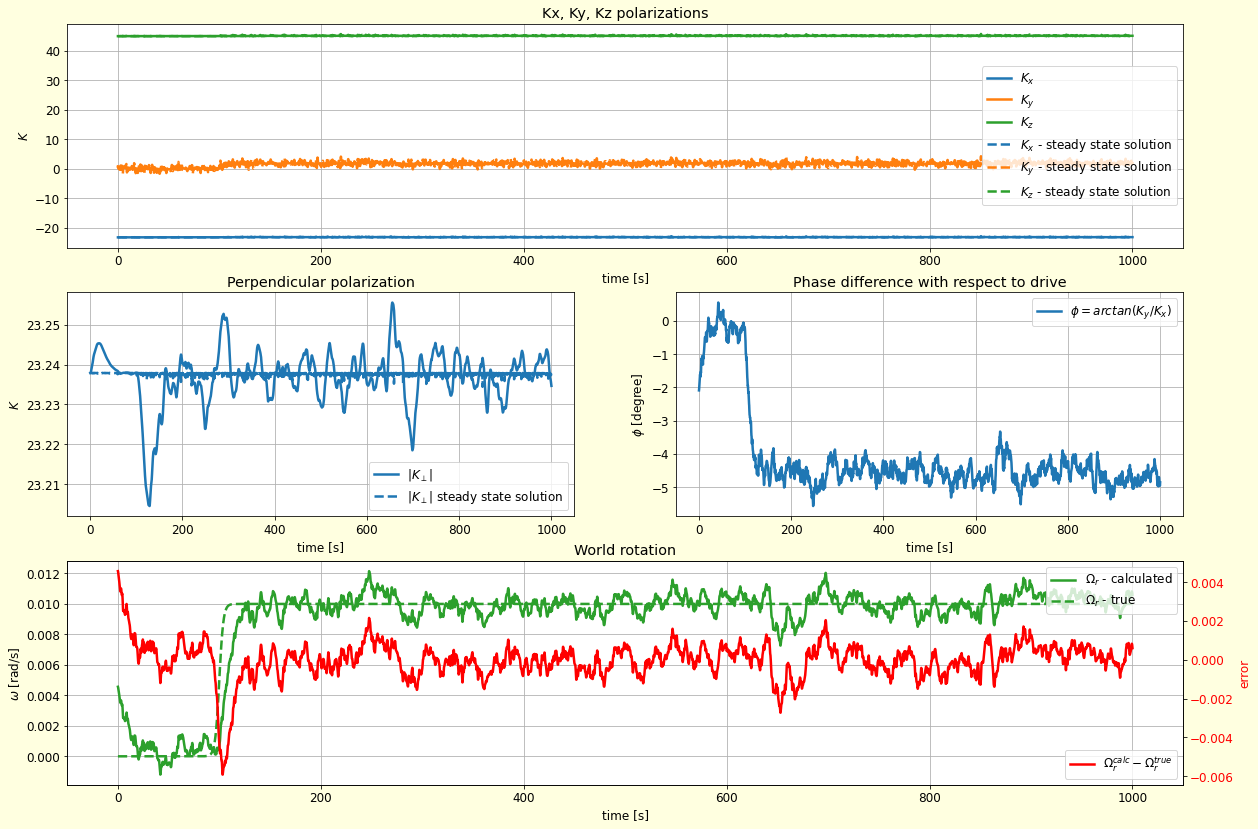

In [26]:
# plot Xenon 129 results
Xe129.plot_results(env129)

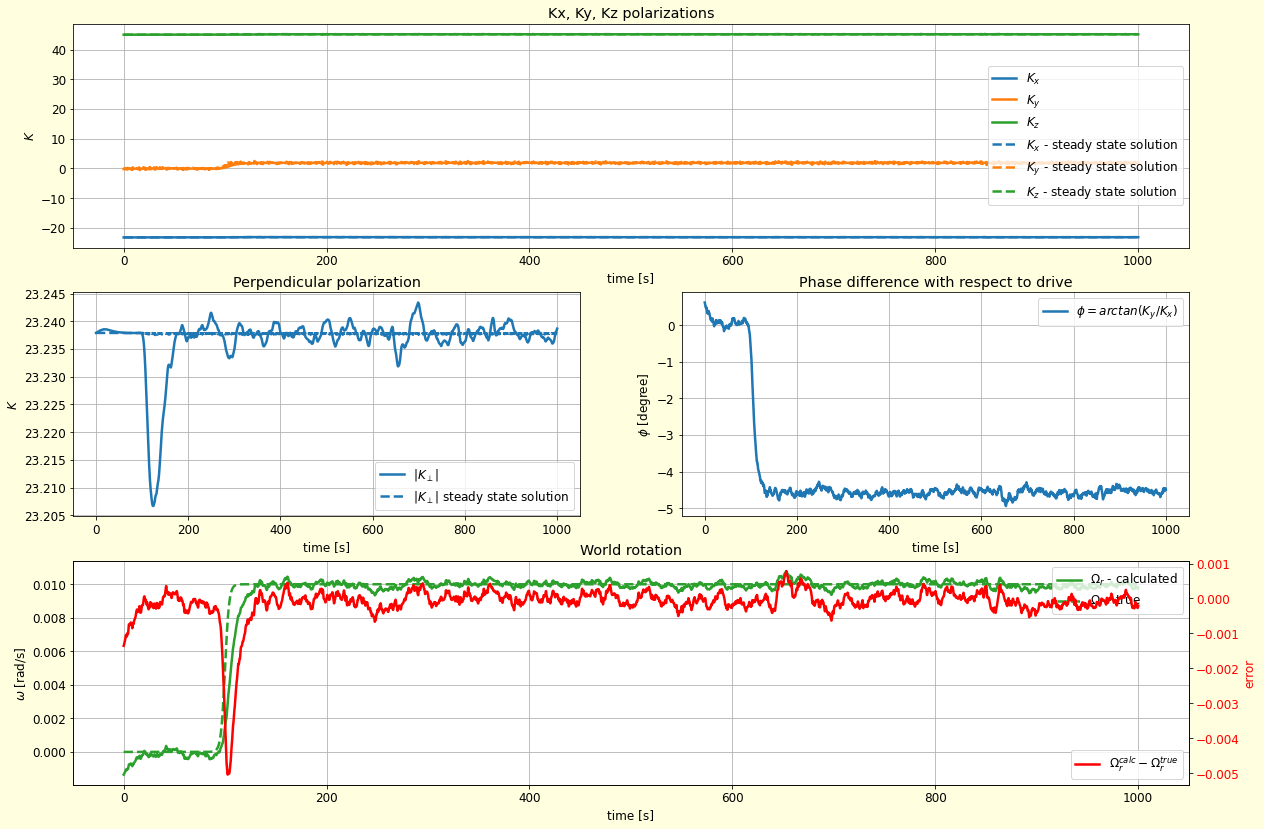

In [27]:
# plot Xenon 131 results
Xe131.plot_results(env131)

In [28]:
# calculating the world rotation using Xenon-129 and Xenon-131 phases (equation above)
A1 = Xe129.gamma * Xe131.gamma / (Xe129.gamma - Xe131.gamma)
A129 = (Xe129.phase_perp * Xe129.gamma2 - env129.wd_y) / Xe129.gamma
A131 = (Xe131.phase_perp * Xe131.gamma2 - env131.wd_y) / Xe131.gamma
world_rotation = A1 * (A129 - A131)

world_rotation_129 = -Xe129.phase_perp * Xe129.gamma2 + Xe129.gamma * env129.B0 - env129.wd_y
world_rotation_131 = -Xe131.phase_perp * Xe131.gamma2 + Xe131.gamma * env131.B0 - env131.wd_y

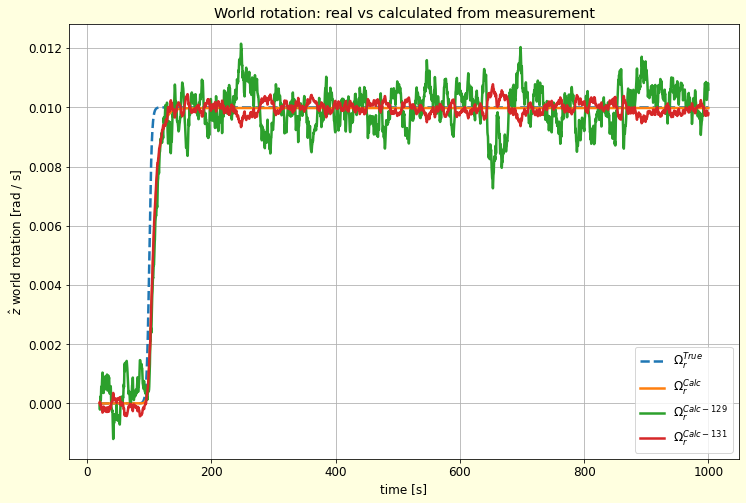

In [32]:
# plot world rotation and z magnetic field

i = 20
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()
ax.set_title('World rotation: real vs calculated from measurement')
ax.plot(ts[ts > i], wr[ts > i], '--', label='$\Omega_r^{True}$')
ax.plot(ts[ts > i], world_rotation[ts > i], label='$\Omega_r^{Calc}$')
ax.plot(ts[ts > i], world_rotation_129[ts > i], label='$\Omega_r^{Calc-129}$')
ax.plot(ts[ts > i], world_rotation_131[ts > i], label='$\Omega_r^{Calc-131}$')
ax.set_ylabel('$\hat{z}$ world rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
ax.grid(True)
plt.show()

We see in the plot above that we are able to extract the world rotation from the two Xenon phases with $0$ error. The case of $0$ error is a result of a special initialization of the two Xenon, where we give both isotops the same $T_1, T_2$ values. If gave them different $T_1, T_2$ values, the subtraction would not be perfect unless the changes in the magnetic noise would be much slower then the decay rates of the two Xenons.  

### $T_1^{129}, T_2^{129} \neq T_1^{}, T_2^{129}$

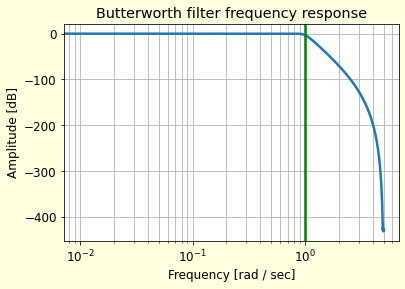

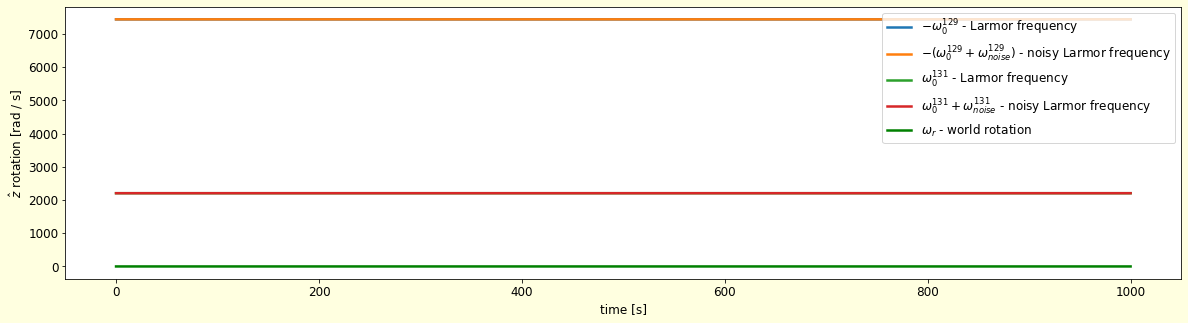

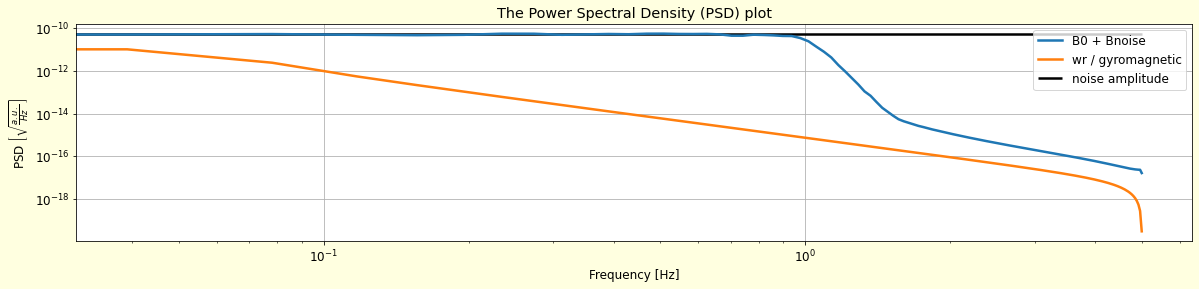

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


KeyboardInterrupt: ignored

In [34]:
#@title Dynamic range
t1_129 = 30 #@param {type:"slider", min:1, max:100, step:1}
t2_129 = 8 #@param {type:"slider", min:1, max:100, step:1}
t1_131 = 30 #@param {type:"slider", min:1, max:100, step:1}
t2_131 = 8 #@param {type:"slider", min:1, max:100, step:1}

# solver and noise parameters
t_final = 1000                               # [s]
dt = 0.1                                      # [s]
sampling_frequency = 1 / dt                 # [Hz]
noise_cutoff_frequency = 1                # [Hz]
noise_amplitude = 5e-7 * phy.G2T            # [Tesla]
steps = int(t_final // dt)
ts = np.linspace(0, t_final, steps)         # [s]
noise = utils.get_white_noise(noise_amplitude, sampling_frequency, ts)  # [Tesla]

# world rotation parameters
#wr = 30 * utils.gaussian(ts, 600, 40)                         # rad / s     
wr = 0.01 * utils.sigmoid(ts, 0.1, 400)                          # rad / s   

# Xenon 129 parameters
g129 = phy.G129                            # gyromagnetic ratio [rad  s^-1  T^-1]
Rse_129 = np.array([0, 0, 0.1]) * t1_129   # |K| / s


# Xenon 131 parameters
g131 = phy.G131                            # gyromagnetic ratio [rad  s^-1  T^-1]
Rse_131 = np.array([0, 0, 0.1]) * t1_131   # |K| / s


# Environmemnt parameters
B0 = 1 * phy.G2T * np.ones_like(ts)                                   # Tesla
Bnoise = utils.butter_low_pass_filter(noise, 10, noise_cutoff_frequency, sampling_frequency, plot_filter=True)
Ad_y_129 = 2 * np.sqrt((1 / t1_129) * (1 / t2_129)) * np.ones_like(ts)  # rad / s
wd_y_129 = g129 * 1e-6 * phy.G2T * np.ones_like(ts)                        # rad / s
Ad_x_129 = np.zeros_like(ts)                                            # rad / s
wd_x_129 = np.zeros_like(ts)                                            # rad / s
Ad_y_131 = 2 * np.sqrt((1 / t1_131) * (1 / t2_131)) * np.ones_like(ts)  # rad / s
wd_y_131 = g131 * 1e-6 * phy.G2T * np.ones_like(ts)                        # rad / s
Ad_x_131 = np.zeros_like(ts)                                            # rad / s
wd_x_131 = np.zeros_like(ts)                                            # rad / s


# initialize Xenon 129
Xe129 = xe.Xenon(gamma=g129, t1=t1_129, t2=t2_129, K0=np.array([0.059, 0.42, -0.1]), ts=t_final, dt=dt, name='129')
Xe129.set_spin_exchange_amp(Rse_129)

# initialize Xenon 131
Xe131 = xe.Xenon(gamma=g131, t1=t1_131, t2=t2_131, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='131')
Xe131.set_spin_exchange_amp(Rse_131)

# initialize Xenon-129 Environment
env129 = env.Environment(name='Xenon-129 environment')
env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y_129, wd_y=wd_y_129, Ad_x=Ad_x_129, wd_x=wd_x_129)

# initialize Xenon-131 Environment
env131 = env.Environment(name='Xenon-131 environment')
env131.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y_131, wd_y=wd_y_131, Ad_x=Ad_x_131, wd_x=wd_x_131)

# plot world rotation
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot()
ax.plot(ts, -Xe129.gamma * B0, label='$-\omega_0^{129}$ - Larmor frequency')
ax.plot(ts, -Xe129.gamma * (B0 + Bnoise), label='$-(\omega_0^{129} + \omega_{noise}^{129})$ - noisy Larmor frequency')
ax.plot(ts, Xe131.gamma * B0, label='$\omega_0^{131}$ - Larmor frequency')
ax.plot(ts, Xe131.gamma * (B0 + Bnoise), label='$\omega_0^{131} + \omega_{noise}^{131}$ - noisy Larmor frequency')
ax.plot(ts, wr, label='$\omega_r$ - world rotation', color='green')
ax.set_ylabel('$\hat{z}$ rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
plt.show()

# PSD plot of all signals
signal_list = [B0 + Bnoise, wr / g129]
names = ['B0 + Bnoise', 'wr / gyromagnetic']
utils.psd_compare(signal_list, sampling_frequency, noise_amplitude=noise_amplitude, names=names, logx=True)


# run solvers for Xenons
Xe129.solve_dynamics(env129)
Xe131.solve_dynamics(env131)

# compute XY polarization values
Xe129.compute_perpendicular_values()
Xe131.compute_perpendicular_values()

# calculating the world rotation using Xenon-129 and Xenon-131 phases (equation above)
A1 = Xe129.gamma * Xe131.gamma / (Xe129.gamma - Xe131.gamma)
A129 = (Xe129.phase_perp * Xe129.gamma2 - env129.wd_y) / Xe129.gamma
A131 = (Xe131.phase_perp * Xe131.gamma2 - env131.wd_y) / Xe131.gamma
world_rotation = A1 * (A129 - A131)

world_rotation_129 = -Xe129.phase_perp * Xe129.gamma2 + Xe129.gamma * env129.B0 - env129.wd_y
world_rotation_131 = -Xe131.phase_perp * Xe131.gamma2 + Xe131.gamma * env131.B0 - env131.wd_y

# plot world rotation and z magnetic field

i = 50
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()
ax.set_title('World rotation: real vs calculated from measurement')
ax.plot(ts[ts > i], wr[ts > i], '--', label='$\Omega_r^{True}$')
ax.plot(ts[ts > i], world_rotation[ts > i], label='$\Omega_r^{Calc}$')
ax.plot(ts[ts > i], world_rotation_129[ts > i], label='$\Omega_r^{Calc-129}$')
ax.plot(ts[ts > i], world_rotation_131[ts > i], label='$\Omega_r^{Calc-131}$')
ax.set_ylabel('$\hat{z}$ world rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
print(Xe129.phase_perp)

None
